# Medical Image Classification using keras

In this tutorial, we will present a few simple yet effective methods that we can use to build a powerful image classifier for endoscopic image classification, using only very few training examples --just a few hundred or thousand pictures from each class you want to be able to recognize.

We will go over the following options:
    <ol><li>training a small network from scratch (as a baseline)</li>
    <li>using the bottleneck features of a pre-trained network</li>
    <li>fine-tuning the top layers of a pre-trained network</li>

Let’s discuss how to train model from scratch and classify the data containing cars and planes.


<ul><li><strong>Train Data</strong> : Train data contains the 614 images of each class, i.e. total their are 3071 images in the test dataset</li>
<li><strong>Validation Data</strong> : Test data contains 80 images of each class i.e. total their are 400 images in the validation dataset</li>
<li><strong>Test Data</strong> : Test data contains 80 images of each class i.e. total their are 400 images in the test dataset</li>
</ul>

For feeding the dataset folders the should be made and provided into this format only. So now, Let’s begins with importing libraries.

In [1]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.callbacks import TensorBoard
from keras.applications.resnet50 import preprocess_input

Using TensorFlow backend.
/home/poudelas/anaconda3/envs/pix2pix/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/poudelas/anaconda3/envs/pix2pix/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/poudelas/anaconda3/envs/pix2pix/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/poude

We use the TensorBoard visualization method in order to check the training and validation process. Here, the DATASET_PATH is the root dataset directory where it contains <i>train</i>, <i>validation</i> and <i>test</i> folders. Every image in the dataset is of the size of 224*224. We set the batch size of 8 depending upon the computing capacity of GPU.

In [2]:
tensorboard = TensorBoard(log_dir='./ResNet',histogram_freq=0,write_graph=True,write_images=False)
DATASET_PATH = '/home/poudelas/Documents/pycharm/data/'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = 5
BATCH_SIZE    = 8  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    =5
WEIGHTS_FINAL = 'ResNet.h5'

<h3>Preparation of the Data</h3>

<ul>
    <li><strong>ImageDataGenerator</strong> includes all possible orientation of the image. we set the preprocessing function done by the default ResNet50 model. All kind of augmentation like shearing, flipping, rotation can be included here if needed.</li>
    <li><strong>train_datagen.flow_from_directory</strong> is the function that is used to prepare data from the train_dataset directory <i>Target_size</i> specifies the target size of the image.</li>
    <li><strong>valid_datagen.flow_from_directory</strong> is used to prepare validation data for the model and all is similar as above.</li>
</ul>

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input
                                       )
train_batches = train_datagen.flow_from_directory(DATASET_PATH + 'train',
                                                      target_size=IMAGE_SIZE,
                                                      class_mode='categorical',
                                                      classes=['adenocarcinoma', 'adenoma',
                                                               'cd', 'normal', 'uc'],
                                                      batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + 'validation',
                                                          target_size=IMAGE_SIZE,
                                                          class_mode='categorical',
                                                          classes=['adenocarcinoma', 'adenoma',
                                                                   'cd', 'normal', 'uc'],
                                                          shuffle=False,
                                                          batch_size=BATCH_SIZE)

Found 3071 images belonging to 5 classes.
Found 400 images belonging to 5 classes.


In our case we will use a very small convnet with four layers and few filters per layer, without data augmentation and dropout.
The code snippet below is our first model, a simple stack of 4 convolution layers with a ReLU activation and followed by GLobal Average pooling layers before softmax layers.

In [19]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(5))
model.add(Activation('softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_54 (Activation)   (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
activation_55 (Activation)   (None, 109, 109, 64)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 52, 52, 128)       73856     
__________

<ul>
    <li><strong>Conv2D</strong> is the layer to convolve the image into multiple images</li>
    <li><strong>Activation</strong> is the activation function.</li>
    <li><strong>MaxPooling2D</strong> is used to max pool the value from the given size matrix and same is used for the next 2 layers.</li>
    <li><strong>Dense</strong> is the output layer contains neurons which decide to which category image belongs.</li>
    
</ul>

We end the model with a softmax activation which will produce probability score for five class, i.e. called multi-class classification. Therefore, we will also use the categorical_crossentropy loss to train our model. If the model has just 2 output in softmax activation function, then binary_crossentropy loss function should be used.

In [20]:
model.compile(SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True),
                      loss='categorical_crossentropy', metrics=['accuracy'])
print('compiled!!!')

compiled!!!


<strong>model.fit_generator</strong> trains the model on data generated batch-by-batch by a Python generator (or an instance of Sequence).

In [21]:
H = model.fit_generator(train_batches,
                            steps_per_epoch = train_batches.samples // BATCH_SIZE,
                            validation_data = valid_batches,
                            validation_steps=valid_batches.samples // BATCH_SIZE,
                            epochs = NUM_EPOCHS,
                            workers=8,
                            callbacks=[checkpoint,tensorboard,reduce_lr]
                            )
model.save(WEIGHTS_FINAL)

Epoch 1/5
383/383 [==============================] - 19s 48ms/step - loss: 1.6819 - acc: 0.2977 - val_loss: 1.5940 - val_acc: 0.3000

Epoch 00001: val_loss did not improve from 1.06778
Epoch 2/5
383/383 [==============================] - 19s 49ms/step - loss: 1.5033 - acc: 0.3487 - val_loss: 1.5166 - val_acc: 0.3250

Epoch 00002: val_loss did not improve from 1.06778
Epoch 3/5
383/383 [==============================] - 19s 48ms/step - loss: 1.4502 - acc: 0.3793 - val_loss: 1.5041 - val_acc: 0.3225

Epoch 00003: val_loss did not improve from 1.06778
Epoch 4/5
383/383 [==============================] - 19s 48ms/step - loss: 1.4234 - acc: 0.3940 - val_loss: 1.4668 - val_acc: 0.3950

Epoch 00004: val_loss did not improve from 1.06778
Epoch 5/5
383/383 [==============================] - 19s 49ms/step - loss: 1.4105 - acc: 0.4009 - val_loss: 1.4272 - val_acc: 0.3675

Epoch 00005: val_loss did not improve from 1.06778


Lets plot the results and visualize how our deep learning works on the above architecture. We use Matplotlib library for this.

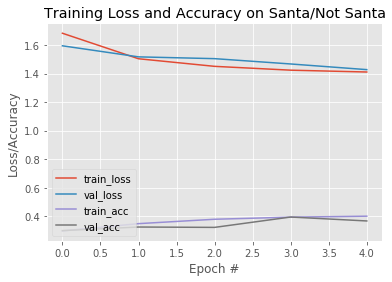

In [25]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = 5
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Santa/Not Santa")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

<h3>Evaluating out 4-layer CNN on testing dataset</h3>

In [26]:
test_batches = train_datagen.flow_from_directory(DATASET_PATH + 'testing',
                                                  target_size=IMAGE_SIZE,
                                                  class_mode='categorical',
                                                  classes=['adenocarcinoma','adenoma','cd','normal','uc'],
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=False)

Found 400 images belonging to 5 classes.


In [32]:
results = model.evaluate_generator(generator=test_batches)
print('Testing loss:' + str(results[0]))
print('Testing Accuracy:' + str(results[1]*100))

Testing loss:1.4073149466514587
Testing Accuracy:40.25


50/50 [==============================] - 10s 196ms/step


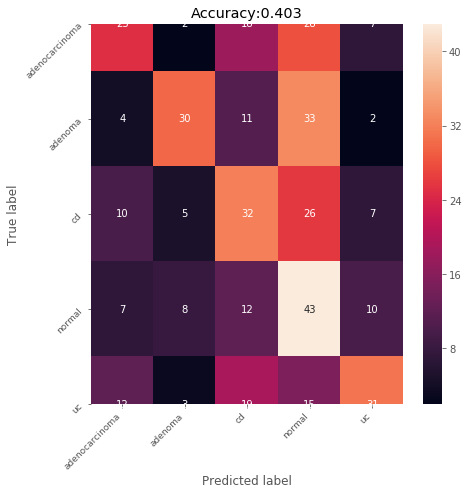

In [37]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,precision_score,recall_score
import pandas as pd
import seaborn as sns

pred=model.predict_generator(test_batches,verbose=1)
y_pred = np.argmax(pred,axis=-1)
cm = confusion_matrix(test_batches.classes, y_pred)
cm_df = pd.DataFrame(cm,
                      index = ['adenocarcinoma','adenoma','cd','normal','uc'],
                      columns = ['adenocarcinoma','adenoma','cd','normal','uc'])

plt.figure(figsize=(7,7))
#sns.heatmap(cm_df, annot=True)
try:
    heatmap = sns.heatmap(cm_df, annot=True, fmt="d")
except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=45, ha='right', fontsize=9)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=9)
plt.title('Accuracy:{0:.3f}'.format(results[1]))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<h2>Transfer Learning</h2>

In [ ]:
# create the base pre-trained model
from keras.applications.resnet50 import ResNet50
original_model = ResNet50(weights='imagenet', include_top=True)
print(original_model.summary())

In [38]:
# create the base pre-trained model
from keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False)
print(base_model.summary())

/home/poudelas/anaconda3/envs/pix2pix/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [40]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
# and a logistic layer --  we have 5 classes
predictions = Dense(5, activation='softmax')(x)

# this is the model we will train
model1 = Model(inputs=base_model.input, outputs=predictions)
print(model1.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [41]:
model1.compile(SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True),
                      loss='categorical_crossentropy', metrics=['accuracy'])
print('compiled!!!')

compiled!!!


The <strong>ModelCheckpoint</strong> callback class allows you to define where to checkpoint the model weights, how the file should named and under what circumstances to make a checkpoint of the model. It can be passed to the training process when calling the fit() function on the model.

In [42]:
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

checkpoint = ModelCheckpoint('/home/poudelas/Documents/learn/resnet-{epoch:05d}--{val_loss:.4f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

<strong>ReduceLROnPlateau:</strong> reduce learning rate when a metric has stopped improving.

Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

In [43]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                   patience=8, min_lr=0.0000001, verbose=1,cooldown=1)

In [47]:

H1 = model1.fit_generator(train_batches,
                            steps_per_epoch = train_batches.samples // BATCH_SIZE,
                            validation_data = valid_batches,
                            validation_steps=valid_batches.samples // BATCH_SIZE,
                            epochs = NUM_EPOCHS,
                            workers=8,
                            callbacks=[checkpoint,tensorboard,reduce_lr]
                            )
model1.save(WEIGHTS_FINAL)

Epoch 1/5
383/383 [==============================] - 35s 90ms/step - loss: 1.0663 - acc: 0.6226 - val_loss: 0.9936 - val_acc: 0.6600

Epoch 00001: val_loss improved from 1.05573 to 0.99365, saving model to /home/poudelas/Documents/learn/resnet-00001--0.9936.h5
Epoch 2/5
383/383 [==============================] - 35s 92ms/step - loss: 1.0277 - acc: 0.6387 - val_loss: 0.9396 - val_acc: 0.6650

Epoch 00002: val_loss improved from 0.99365 to 0.93960, saving model to /home/poudelas/Documents/learn/resnet-00002--0.9396.h5
Epoch 3/5
383/383 [==============================] - 35s 93ms/step - loss: 0.9711 - acc: 0.6581 - val_loss: 0.8891 - val_acc: 0.6925

Epoch 00003: val_loss improved from 0.93960 to 0.88906, saving model to /home/poudelas/Documents/learn/resnet-00003--0.8891.h5
Epoch 4/5
383/383 [==============================] - 36s 93ms/step - loss: 0.9344 - acc: 0.6631 - val_loss: 0.8482 - val_acc: 0.7075

Epoch 00004: val_loss improved from 0.88906 to 0.84816, saving model to /home/poude

In [51]:
results = model1.evaluate_generator(generator=test_batches)
print('Testing loss:' + str(results[0]))
print('Testing Accuracy:' + str(results[1]*100))

Testing loss:0.7817106163501739
Testing Accuracy:73.75


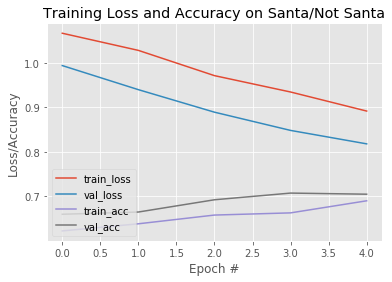

In [52]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = 5
plt.plot(np.arange(0, N), H1.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H1.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H1.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H1.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Santa/Not Santa")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

50/50 [==============================] - 10s 198ms/step


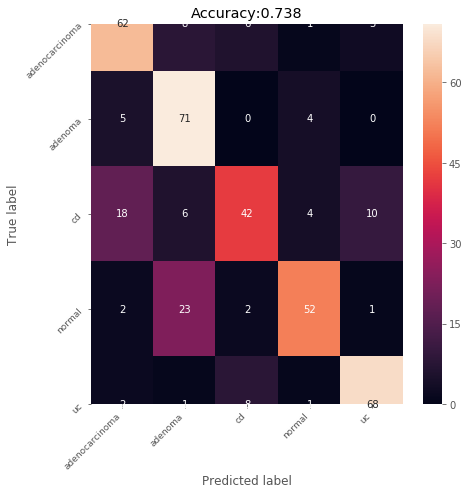

In [53]:
pred1=model1.predict_generator(test_batches,verbose=1)
y_pred1 = np.argmax(pred,axis=-1)
cm = confusion_matrix(test_batches.classes, y_pred1)
cm_df = pd.DataFrame(cm,
                      index = ['adenocarcinoma','adenoma','cd','normal','uc'],
                      columns = ['adenocarcinoma','adenoma','cd','normal','uc'])

plt.figure(figsize=(7,7))
#sns.heatmap(cm_df, annot=True)
try:
    heatmap = sns.heatmap(cm_df, annot=True, fmt="d")
except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=45, ha='right', fontsize=9)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=9)
plt.title('Accuracy:{0:.3f}'.format(results[1]))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<h3>GradCAM</h3> Class activation maps are a simple technique to get the discriminative image regions used by a CNN to identify a specific class in the image. In other words, a class activation map (CAM) lets us see which regions in the image were relevant to this class.

In [65]:
from keras.preprocessing import image

img_path = '/home/poudelas/Documents/pycharm/data/testing/adenoma/12722703(3).jpg'

# We preprocess the image into a 4D tensor
img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
print(img_tensor.shape)
img_tensor1 = np.expand_dims(img_tensor, axis=0)
print(img_tensor1.shape)
img_tensor2 = preprocess_input(img_tensor1)

print(img_tensor2.shape)

(224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


In [56]:
for i,layer in enumerate(model1.layers):
    print(i,layer.name)

0 input_2
1 conv1_pad
2 conv1
3 bn_conv1
4 activation_59
5 pool1_pad
6 max_pooling2d_10
7 res2a_branch2a
8 bn2a_branch2a
9 activation_60
10 res2a_branch2b
11 bn2a_branch2b
12 activation_61
13 res2a_branch2c
14 res2a_branch1
15 bn2a_branch2c
16 bn2a_branch1
17 add_17
18 activation_62
19 res2b_branch2a
20 bn2b_branch2a
21 activation_63
22 res2b_branch2b
23 bn2b_branch2b
24 activation_64
25 res2b_branch2c
26 bn2b_branch2c
27 add_18
28 activation_65
29 res2c_branch2a
30 bn2c_branch2a
31 activation_66
32 res2c_branch2b
33 bn2c_branch2b
34 activation_67
35 res2c_branch2c
36 bn2c_branch2c
37 add_19
38 activation_68
39 res3a_branch2a
40 bn3a_branch2a
41 activation_69
42 res3a_branch2b
43 bn3a_branch2b
44 activation_70
45 res3a_branch2c
46 res3a_branch1
47 bn3a_branch2c
48 bn3a_branch1
49 add_20
50 activation_71
51 res3b_branch2a
52 bn3b_branch2a
53 activation_72
54 res3b_branch2b
55 bn3b_branch2b
56 activation_73
57 res3b_branch2c
58 bn3b_branch2c
59 add_21
60 activation_74
61 res3c_branch2a
6

In [59]:
preds = model1.predict(img_tensor2)
print(preds)

[[0.06903134 0.7609367  0.05109048 0.0623938  0.05654772]]


In [60]:
np.argmax(preds[0])

1

In [61]:
from keras import backend as K
# This is the "adenoma image" entry in the prediction vector
uc = model1.output[:, 1]

# # The is the output feature map of the `block5_conv3` layer,
# # the last convolutional layer in ResNet50
last_conv_layer = model1.get_layer('res5c_branch2c')

# # This is the gradient of the "adenoma image" class with regard to
# # the output feature map of `res2a_branch2a`
grads = K.gradients(uc, last_conv_layer.output)[0]

# # This is a vector of shape (2048,), where each entry
# # is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# # This function allows us to access the values of the quantities we just defined:
# # `pooled_grads` and the output feature map of `res5c_branch2c`,
# # given a sample image
iterate = K.function([model1.input], [pooled_grads, last_conv_layer.output[0]])

# # These are the values of these two quantities, as Numpy arrays,
# # given our sample image of colitis
pooled_grads_value, conv_layer_output_value = iterate([img_tensor2])

# # We multiply each channel in the feature map array
# # by "how important this channel is" with regard to the adenoma class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# # The channel-wise mean of the resulting feature map
# # is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)
#heatmap = conv_layer_output_value[:, :, 11]

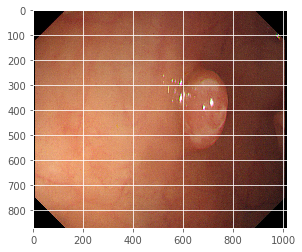

In [67]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import *

im = np.array(Image.open('/home/poudelas/Documents/pycharm/data/testing/adenoma/12722703(3).jpg')
)

plt.imshow(im)
plt.show()

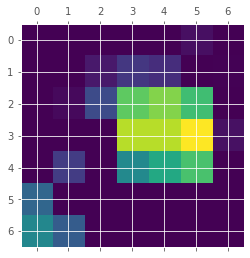

In [62]:
import matplotlib.pyplot as plt

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()